In [1]:
#      matplotlib widget
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import aseg_gdf2
from shapely.geometry import Point, LineString, MultiPoint, Polygon
from shapely.wkt import loads
from scipy.io import loadmat
from scipy import spatial
import matplotlib.pyplot as plt
import rasterio
import netCDF4
import h5py
import gc
import os
import glob
from scipy.spatial.ckdtree import cKDTree
from hydrogeol_utils import SNMR_utils, spatial_functions, AEM_utils
from hydrogeol_utils import plotting_utils as plot_utils

In [3]:
def in_bounds(coords, b):
    """
    Function return true if point is within raster bounds
    coords = 1d numpy array (x,y)
    b = raseter dataset bounds from rasterio
    """
    x,y = coords[0], coords[1]
    
    if np.all([x > b.left, x < b.right,
                     y > b.bottom, y < b.top]):
        return True
    else:
        return False

In [4]:
def nearest_neighbours(points, coords, points_required = 1, max_distance = 250.):
    """

    :param points: array of points to find the nearest neighbour for
    :param coords: coordinates of points
    :param points_required: number of points to return
    :param max_distance: maximum search radius
    :return:
    """
    # Initialise tree instance
    kdtree = cKDTree(data=coords)

    # iterate throught the points and find the nearest neighbour
    distances, indices = kdtree.query(points, k=points_required,
                                      distance_upper_bound=max_distance)
    print(distances)
    # Mask out infitnite distances in indices to avoid confusion
    mask = ~np.isfinite(distances)

    distances[mask] = np.nan

    return distances, indices

# Find the nearest neighbours within the maximum distance

def xy_2_var(grid_dict, xy, var):
    """
    Function for finding a variable for gridded AEM sections
    given an input easting and northing
    @ param: grid_dict :dictionary for gridded line data
    @ param: xy: numpy array with easting and northing
    @ param: var: string with variable name
    returns
    float: distance along line
    """
    utm_coords = np.column_stack((grid_dict['easting'],
                                  grid_dict['northing']))

    d, i = spatial_functions.nearest_neighbours(xy,
                                                utm_coords,
                                                points_required=1,
                                                max_distance=100.)
    if np.isnan(d[0]):
        return None

    else:
        near_ind = i[0]
    


        return grid_dict[var][near_ind]


In [5]:
infile = r"C:\Users\PCUser\Desktop\AEM\LCI\DalyR_WB_MGA52.nc"

lci_dat = netCDF4.Dataset(infile)

lci_coords = np.column_stack((lci_dat['easting'][:],
                          lci_dat['northing'][:]))

# Initialise tree instance for nearest neighbour searches
kdtree = cKDTree(data=lci_coords)


In [6]:
# Since we will be wanting to plot the sections lets first grid them

# Create an instance of plots for gridding the data

plots = plot_utils.ConductivitySectionPlot(lci_dat)


# Define some key variables which we want to inteprolate

cond_vars = ['conductivity', 'data_residual', 'depth_of_investigation']

plots.conductivity_variables = cond_vars


# Define the resolution of th sections
xres, yres = 20., 4.


In [7]:
lines = [int(x) for x in lci_dat['line'][:]]

In [8]:

# Now grid the lines and save in memory

hdf5_dir = r"C:\Users\PCUser\Desktop\NSC_data\data\AEM\DR\lci\hdf5"

if not os.path.exists(hdf5_dir):
    os.mkdir(hdf5_dir)

gridded_vars ={}

# Saved these out to save time

#gridded_vars = plots.grid_variables(xres = xres, yres =yres, lines=lines,
#                                    resampling_method = 'linear', save_hdf5 = True,
#                                   return_dict = True, hdf5_dir = hdf5_dir)

for line in lines:
    
    infile = os.path.join(hdf5_dir, str(line) + '.hdf5')
    f = h5py.File(infile, 'r')
    gridded_vars[line] = plot_utils.extract_hdf5_data(f, cond_vars)
    f = None
    gc.collect()

In [9]:
gridded_vars.keys()

dict_keys([100001, 100101, 100201, 100301, 100401, 100501, 100601, 100701, 100801, 100901, 101001, 101101, 101201, 101301, 101401, 101501, 101502, 101601, 101701, 101801, 101901, 102001, 102101, 102201, 102301, 102401, 102501, 102601, 102701, 102801, 102901, 103001, 103101, 103201, 103301, 103401, 103501, 103502, 103601, 103701, 103801, 103901, 104001, 104101, 104102, 104201, 104301, 104302, 104401, 104501, 104601, 104701, 104801, 104901, 105001, 105101, 105201, 105301, 105401, 105501, 105601, 105602, 105603, 105701, 105801, 105901, 105902, 106001, 106101, 106201, 106301, 106302, 106401, 106501, 106601, 106701, 106801, 106901, 107001, 107101, 107201, 107301, 107401, 107501, 107601, 107701, 107801, 107901, 108001, 108101, 108201, 108301, 108401, 108501, 108601, 108701, 108801, 108901, 109001, 109101, 109201, 109202, 109203, 109204, 109301, 109302, 109303, 109401, 109402, 109501, 109502, 109503, 109504, 109601, 109701, 109702, 109703, 109801, 109802, 109803, 109901, 110001, 110002, 11000

In [10]:
# Now we bring in the Leap frog surfaces

indir = r"C:\Users\PCUser\Desktop\NSC_data\data\raster\Daly_Aquifers\sectoinExport"

rasters = {}


for file in glob.glob(os.path.join(indir, '*.grd')):
    inRaster = os.path.join(indir,file)

    contact_dataset = rasterio.open(inRaster)

    #contact_elev = contact_dataset.read(1)

    #contact_elev[contact_elev == contact_dataset.get_nodatavals()] = np.nan
    
    rasters[file.split('\\')[-1].split('.')[0]] = contact_dataset

# Now bring in the new raster

infile = r"C:\Users\PCUser\Desktop\NSC_data\DR_interp\raster\Ollo_Jind_contact_mAHD_v2.tif"

inRaster = os.path.join(indir,infile)

rasters['OollooJind_GA'] = rasterio.open(inRaster)


In [11]:
rasters

{'baseCret': <open DatasetReader name='C:\Users\PCUser\Desktop\NSC_data\data\raster\Daly_Aquifers\sectoinExport\baseCret.grd' mode='r'>,
 'baseTind': <open DatasetReader name='C:\Users\PCUser\Desktop\NSC_data\data\raster\Daly_Aquifers\sectoinExport\baseTind.grd' mode='r'>,
 'OllooJind_contact': <open DatasetReader name='C:\Users\PCUser\Desktop\NSC_data\data\raster\Daly_Aquifers\sectoinExport\OllooJind_contact.grd' mode='r'>,
 'TindJind_contact': <open DatasetReader name='C:\Users\PCUser\Desktop\NSC_data\data\raster\Daly_Aquifers\sectoinExport\TindJind_contact.grd' mode='r'>,
 'TopFlor': <open DatasetReader name='C:\Users\PCUser\Desktop\NSC_data\data\raster\Daly_Aquifers\sectoinExport\TopFlor.grd' mode='r'>,
 'OollooJind_GA': <open DatasetReader name='C:\Users\PCUser\Desktop\NSC_data\DR_interp\raster\Ollo_Jind_contact_mAHD_v2.tif' mode='r'>}

In [12]:
contact_dataset.bounds.left

672135.5919063305

In [13]:
# We want to find the top of the contacts for each unit at each point on the grid

for line in gridded_vars.keys():
    
    # Get the coordinates
    utm_coords = np.column_stack((gridded_vars[line]['easting'],
                                  gridded_vars[line]['northing']))
    
    for item in rasters.keys():
    
        # sample the raster at the coordinates
        contact_dataset = rasters[item]
    
        #elevGen = contact_dataset.sample(utm_coords)
    
        gridded_vars[line][item] = np.nan*np.ones(shape = utm_coords.shape[0],
                                                  dtype = np.float)
    
        for i in range(utm_coords.shape[0]):
            
            if not in_bounds(utm_coords[i], contact_dataset.bounds):
                
                pass
            
            else:
                
                surfaceElev = next(contact_dataset.sample([utm_coords[i]]))[0]
                
                # If the values of the surface is not a null
                if not np.isclose(surfaceElev,
                                  contact_dataset.get_nodatavals()[0]):
                    if surfaceElev < gridded_vars[line]['elevation'][i]:
                        gridded_vars[line][item][i] = surfaceElev


In [14]:
gridded_vars[line][item][i]


-258.19439697265625

In [20]:
def grid_aspect_ratio(gridded_var):
    w = gridded_var['grid_distances'][-1]
    h = gridded_var['grid_elevations'][0] - gridded_vars[106301]['grid_elevations'][-1]
    
    return w/h

def panel_aspect_ratio(fig, ax):
    bbox = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    w,h = bbox.width, bbox.height
    return w/h
    
def section_plot(line, figsize = (12,3)):
    fig = plt.figure(figsize = figsize)

    # These are for interactive widget mode
    #fig.canvas.layout.width = '6in'
    #fig.canvas.layout.height= '2in'

    ax2 = fig.add_axes([0.08, 0.3, 0.8, 0.45])
    ax1 = fig.add_axes([0.08, 0.75, 0.8, 0.15])
    
    ax1.get_shared_x_axes().join(ax1, ax2)
    
    cbar_ax = fig.add_axes([0.9, 0.1, 0.01, 0.6])
    
    panel_kwargs = [{'title': '',
                      'color': 'black',
                      'ylabel': 'data \n residual',
                      'legend': False},
                     {'title': 'LCI conductivity',
                      'max_depth': 500.,
                      'shade_doi': False,
                      'colourbar': True,
                      'colourbar_label': 'Conductivity (S/m)',
                      'log_plot': True,
                      'vmin': 0.001,
                      'vmax': 1.,
                      'cmap': 'jet',
                      'ylabel': 'elevation \n (mAHD)'}]

    res1 = plot_utils.plot_single_line(ax1, gridded_vars[line],
                                       'data_residual', panel_kwargs[0])

    ax1.set_title('LCI conductivity section - ' + str(line))

    im2 = plot_utils.plot_grid(ax2, gridded_vars[line], 'conductivity',
                               panel_kwargs[1])
    
    # PLot jinduckin elevation onto section
    
    ax2.plot(gridded_vars[line]['grid_distances'],
            gridded_vars[line]['OollooJind_GA'], c = 'k',
            linestyle = 'solid', label = 'Oolloo Jinduckin - GA')
    
    ax2.plot(gridded_vars[line]['grid_distances'],
            gridded_vars[line]['OllooJind_contact'], c = 'white',
            linestyle = 'dashed', label = 'Oolloo Jinduckin - DENR2018')
    
    ax2.plot(gridded_vars[line]['grid_distances'],
            gridded_vars[line]['TindJind_contact'], c = 'red',
            linestyle = 'dashed', label = 'Jinduckin Tindall - DENR2018')
    
    ax2.plot(gridded_vars[line]['grid_distances'],
            gridded_vars[line]['baseTind'], c = 'grey',
            linestyle = 'dashed', label = 'base Tindall - DENR2018')
    

    
    ax2.plot(gridded_vars[line]['grid_distances'],
            gridded_vars[line]['TopFlor'], c = 'pink',
            linestyle = 'dashed', label = 'Florina top - BOM')
    
        
    cb2 = fig.colorbar(im2, cax=cbar_ax, orientation='vertical')
    
    cb2.ax.set_yticklabels([round(10 ** x, 4) for x in cb2.get_ticks()])
    cb2.set_label('conductivity (S/m)', fontsize=10)
    
    
    return fig, ax1, ax2

def plot_lines_in_bin(bin_number, w, h):
    
    for idx in np.where(bins == bin_number)[0]:
        
        line = int(lens[idx,0])
        
        print(line)
        
        fig, ax1, ax2 = section_plot(line, figsize = (w,h))


        plot_utils.add_axis_coords('easting', gridded_vars[line]['easting'],
                            ax2, ax2.get_position(), offset=-0.15)

        plot_utils.add_axis_coords('northing', gridded_vars[line]['northing'],
                            ax2, ax2.get_position(), offset=-0.4)

        ax2.legend(loc='lower right')
        
        # Calculate the vertical exagerration
        gar = grid_aspect_ratio(gridded_vars[line])
    
        par = panel_aspect_ratio(fig, ax2)

    
        vex = gar/par
        
        print(gar)
        print(par)
    
        print("Vertical exaggeration is ", vex)

        outdir = r"C:\Users\PCUser\Desktop\NSC_data\reporting\Daly\sections"

        plt.savefig(os.path.join(outdir, str(line) + ".png"),
                   dpi=300)
        
        plt.close('all')

In [21]:
def xy_to_grid_dist(gridded_var, x, y, use_easting = True):
    if use_easting:
        idx = np.argmin(np.abs(gridded_var['easting'] - x))
    else:
        idx = np.argmin(np.abs(gridded_var['northing'] - y))
    print(np.sqrt(np.add(np.square(gridded_var['easting'][idx] - x),
                         np.square(gridded_var['northing'][idx] - y))))
    
    return idx
    

103601
33738.05933473585


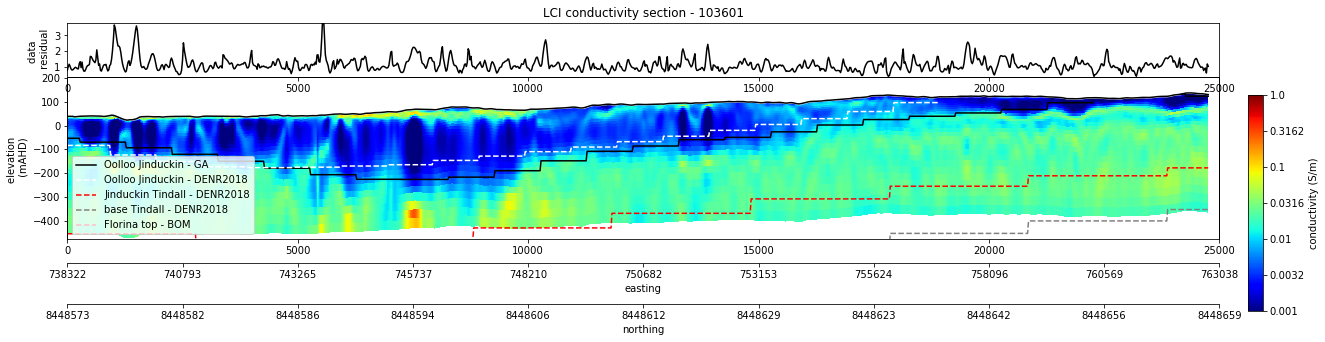

In [28]:
# Now we will do some plotting of sections around a particular feature of interest

line = 103601
        
print(line)

w,h = 20,5

x,y = 762439.06, 8423619.75 

idx = xy_to_grid_dist(gridded_vars[line], x,y, use_easting = False)

fig, ax1, ax2 = section_plot(line, figsize = (w,h))



ax2.legend(loc='lower left')

offset = 5000.

dist = gridded_vars[line]['grid_distances'][idx]

elev = gridded_vars[line]['elevation'][idx]

#ax2.set_xlim(dist - offset, dist + offset)

xmin = 0
xmax = 25000
ax2.set_xlim(xmin, xmax)

#ax2.scatter([dist], [elev], c = 'k', s = 50)

#ax2.set_xlabel('Distance along flightline')

mask = np.logical_and(gridded_vars[line]['grid_distances'] > xmin,
                      gridded_vars[line]['grid_distances'] < xmax) 

plot_utils.add_axis_coords('easting', gridded_vars[line]['easting'][mask],
                            ax2, ax2.get_position(), offset=-0.15)

plot_utils.add_axis_coords('northing', gridded_vars[line]['northing'][mask],
                            ax2, ax2.get_position(), offset=-0.4)

plt.savefig(r"C:\Users\PCUser\Desktop\NSC_data\reporting\Daly\custom_sections\\" + str(line) + '_report_section.png',
           dpi =300)

plt.show()

109201
61191.61134685774


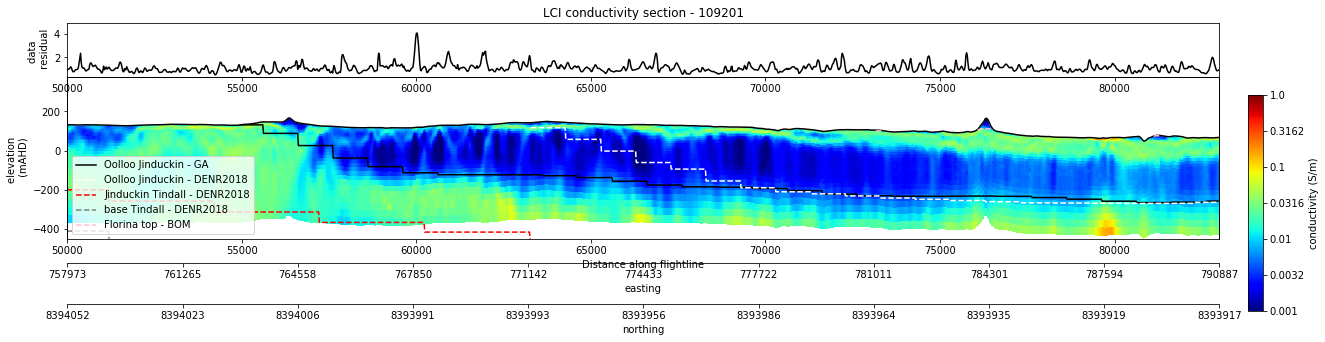

In [23]:
# Now we will do some plotting of sections around a particular feature of interest

line = 109201
        
print(line)

w,h = 20,5

x,y = 762439.06, 8423619.75 

idx = xy_to_grid_dist(gridded_vars[line], x,y, use_easting = False)

fig, ax1, ax2 = section_plot(line, figsize = (w,h))



ax2.legend(loc='lower left')

offset = 5000.

dist = gridded_vars[line]['grid_distances'][idx]

elev = gridded_vars[line]['elevation'][idx]

#ax2.set_xlim(dist - offset, dist + offset)

xmin = 50000
xmax = 83000
ax2.set_xlim(xmin, xmax)

ax2.scatter([dist], [elev], c = 'k', s = 50)

ax2.set_xlabel('Distance along flightline')

mask = np.logical_and(gridded_vars[line]['grid_distances'] > xmin,
                      gridded_vars[line]['grid_distances'] < xmax) 

plot_utils.add_axis_coords('easting', gridded_vars[line]['easting'][mask],
                            ax2, ax2.get_position(), offset=-0.15)

plot_utils.add_axis_coords('northing', gridded_vars[line]['northing'][mask],
                            ax2, ax2.get_position(), offset=-0.4)

plt.savefig(r"C:\Users\PCUser\Desktop\NSC_data\reporting\Daly\custom_sections\\" + str(line) + '_report_section.png',
           dpi =300)

plt.show()

In [41]:
mask = np.logical_and(gridded_vars[line]['grid_distances'] > xmin,
                      gridded_vars[line]['grid_distances'] < xmax) 

In [133]:
lens = np.ones(shape = (len(lines), 2),
                       dtype = np.float)

for i, item in enumerate(lines):
    lens[i] = [item, gridded_vars[item]['grid_distances'][-1]]
    
hist, bin_edges = np.histogram(lens[:,1], bins=10)

# Put all the lines into a length bin

bins = np.ones(shape = len(lines), dtype = np.int)

for i in range(len(bins)):
    bins[i] = np.searchsorted(bin_edges, lens[i,1])
    

In [134]:
plot_lines_in_bin(0, 12,4)

104302
6.317829597484151
5.333333333333333
Vertical exaggeration is  1.1845930495282784


In [135]:
plot_lines_in_bin(1, 12,6)

100101
20.851639497358253
3.555555555555556
Vertical exaggeration is  5.864523608632008
100201
21.129141638679968
3.555555555555556
Vertical exaggeration is  5.942571085878741
100301
21.814404777903118
3.555555555555556
Vertical exaggeration is  6.135301343785251
100401
21.736887930659652
3.555555555555556
Vertical exaggeration is  6.1134997304980265
100501
21.919697169695723
3.555555555555556
Vertical exaggeration is  6.164914828976922
100801
27.7728330009718
3.555555555555556
Vertical exaggeration is  7.8111092815233185
100901
26.50258655801349
3.555555555555556
Vertical exaggeration is  7.453852469441293
101001
26.182341736569857
3.555555555555556
Vertical exaggeration is  7.363783613410272
101101
23.81900518271344
3.555555555555556
Vertical exaggeration is  6.6990952076381545
101201
23.726373288993205
3.555555555555556
Vertical exaggeration is  6.673042487529338
101301
23.854859448172064
3.555555555555556
Vertical exaggeration is  6.709179219798393
101401
24.47706490548692
3.555555

In [136]:
plot_lines_in_bin(2, 16, 5)

100601
27.772926504421356
5.688888888888888
Vertical exaggeration is  4.881959737105317
100701
27.70425321318749
5.688888888888888
Vertical exaggeration is  4.8698882601306135
102201
29.899360395659713
5.688888888888888
Vertical exaggeration is  5.25574694454956
102301
31.734452648884652
5.688888888888888
Vertical exaggeration is  5.578321754686756
102401
31.265961937169834
5.688888888888888
Vertical exaggeration is  5.495969871768136
102501
29.035200354611707
5.688888888888888
Vertical exaggeration is  5.10384381233409
102601
31.149302336520552
5.688888888888888
Vertical exaggeration is  5.475463301341504
102701
31.340929847895946
5.688888888888888
Vertical exaggeration is  5.50914782482546
102801
32.11857103764691
5.688888888888888
Vertical exaggeration is  5.645842565211371
102901
33.25987532930137
5.688888888888888
Vertical exaggeration is  5.846462460228758
103001
33.969210694440115
5.688888888888888
Vertical exaggeration is  5.971150317382052
103101
31.877100647403395
5.688888888

In [137]:
plot_lines_in_bin(3, 16, 5)

101502
56.481314242181334
5.688888888888888
Vertical exaggeration is  9.928356019133439
109302
47.46156119768259
5.688888888888888
Vertical exaggeration is  8.342852554280144
109502
48.6237034618866
5.688888888888888
Vertical exaggeration is  8.547135374159755
109802
48.448620044919394
5.688888888888888
Vertical exaggeration is  8.516358992270987
110001
51.84837142302216
5.688888888888888
Vertical exaggeration is  9.113971539203115
110002
60.926077871093696
5.688888888888888
Vertical exaggeration is  10.70966212577819
110102
57.50336532801597
5.688888888888888
Vertical exaggeration is  10.108013436565308
110301
47.15909159052143
5.688888888888888
Vertical exaggeration is  8.289684068646345


In [138]:
plot_lines_in_bin(4, 20, 5)

105602
68.07441133983527
7.111111111111111
Vertical exaggeration is  9.572964094664334
105902
76.709231298833
7.111111111111111
Vertical exaggeration is  10.787235651398392
109301
64.26051560379919
7.111111111111111
Vertical exaggeration is  9.036635006784262
109401
65.51294106619778
7.111111111111111
Vertical exaggeration is  9.212757337434065
109402
83.69426954947963
7.111111111111111
Vertical exaggeration is  11.769506655395574
109503
57.6797165553347
7.111111111111111
Vertical exaggeration is  8.111210140593943
109702
63.294799083528886
7.111111111111111
Vertical exaggeration is  8.90083112112125


In [139]:
plot_lines_in_bin(5, 22, 5)

101501
88.54003351807488
7.822222222222223
Vertical exaggeration is  11.319038375890253
103501
72.15932582417445
7.822222222222223
Vertical exaggeration is  9.224913812749573
109204
89.8702915731734
7.822222222222223
Vertical exaggeration is  11.489099774979554
109801
86.27843829818543
7.822222222222223
Vertical exaggeration is  11.029913986983933


In [140]:
plot_lines_in_bin(6, 24, 5)

100001
110.22849411006288
8.533333333333335
Vertical exaggeration is  12.917401653522992
103502
89.33639754732545
8.533333333333335
Vertical exaggeration is  10.469109087577198
105601
100.01535578211357
8.533333333333335
Vertical exaggeration is  11.720549505716432
105901
100.57111859374136
8.533333333333335
Vertical exaggeration is  11.785677960204064
109701
96.4327838864667
8.533333333333335
Vertical exaggeration is  11.300716861695314
109901
111.95097237208378
8.533333333333335
Vertical exaggeration is  13.119254574853565


In [141]:
plot_lines_in_bin(7, 24, 5)

109201
109.73591207344556
8.533333333333335
Vertical exaggeration is  12.8596771961069
110003
118.97538845497465
8.533333333333335
Vertical exaggeration is  13.942428334567339


In [142]:
plot_lines_in_bin(7, 24, 4)

109201
109.73591207344556
10.666666666666666
Vertical exaggeration is  10.287741756885522
110003
118.97538845497465
10.666666666666666
Vertical exaggeration is  11.153942667653874


In [143]:
plot_lines_in_bin(8, 25, 3)

In [144]:
plot_lines_in_bin(9, 25, 3)

106301
134.97395833333334
14.814814814814813
Vertical exaggeration is  9.110742187500001


In [145]:
plot_lines_in_bin(10, 30, 4)

104501
167.6185209634908
13.333333333333332
Vertical exaggeration is  12.57138907226181
110201
185.5386466588321
13.333333333333332
Vertical exaggeration is  13.91539849941241
